<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/30_days_deep_learning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 3-1,低阶API示范

# 下面的范例使用TensorFlow的低阶API实现线性回归模型和DNN二分类模型。

# 低阶API主要包括张量操作，计算图和自动微分。

import tensorflow as tf
#打印时间分割线
@tf.function
def printbar():
  today_ts = tf.timestamp()%(24*60*60)

  hour = tf.cast(today_ts//3600+2,tf.int32)%tf.constant(24)
  minite = tf.cast((today_ts%3600)//60,tf.int32)
  second = tf.cast(tf.floor(today_ts%60),tf.int32)

  def timeformat(m):
    if tf.strings.length(tf.strings.format("{}",m))==1:
      return(tf.strings.format("0{}",m))
    else:
      return(tf.strings.format("{}",m))

  timestring = tf.strings.join([timeformat(hour),timeformat(minite),timeformat(second)],separator = ":")
  tf.print("=========="*8+timestring)



In [2]:
# 一，线性回归模型
# 1，准备数据

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

#样本数量
n = 400
## 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10)
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0) # @表示矩阵乘法,增加正态扰动

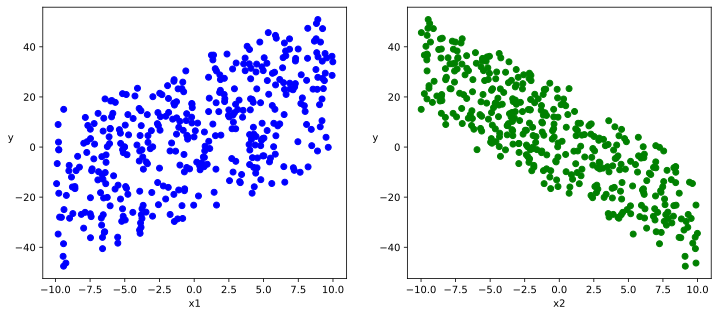

In [3]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [4]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)

# 测试数据管道效果 
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 3.2781677   7.5567284 ]
 [ 6.8723297  -7.660711  ]
 [ 0.93779373  4.471958  ]
 [ 4.94514     4.2456865 ]
 [-1.4465694  -8.217756  ]
 [ 5.239126   -6.0008574 ]
 [ 1.346817   -9.581952  ]
 [-8.58802    -0.6190109 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-13.782343 ]
 [ 39.04231  ]
 [ -6.859765 ]
 [ -3.5243523]
 [ 26.888588 ]
 [ 33.439007 ]
 [ 34.771885 ]
 [-16.5938   ]], shape=(8, 1), dtype=float32)


In [5]:
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 4.063217   -1.5255117 ]
 [-8.840111   -0.6791191 ]
 [ 4.091303   -6.6893196 ]
 [-7.7189612  -4.579227  ]
 [-0.53520966  2.767396  ]
 [-9.443617    9.098965  ]
 [ 5.336709   -9.97711   ]
 [-1.2731266  -2.617917  ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 19.249453 ]
 [-11.982898 ]
 [ 31.429852 ]
 [  2.1318722]
 [ -8.153992 ]
 [-43.608295 ]
 [ 45.669422 ]
 [  5.1482725]], shape=(8, 1), dtype=float32)


In [6]:
#定义模型
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))
# 定义模型
class LinearRegression:     
    #正向传播
    def __call__(self,x): 
        return x@w + b

    # 损失函数
    def loss_func(self,y_true,y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()


In [7]:
#训练模型
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    predictions = model(features)
    loss = model.loss_func(labels, predictions)

  # 反向传播求梯度
  dloss_dw,dloss_db = tape.gradient(loss,[w,b])
  # 梯度下降法更新参数
  w.assign(w - 0.001*dloss_dw)
  b.assign(b - 0.001*dloss_db)

  return loss

In [8]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=326.93634>

In [13]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================21:14:19
epoch = 50 loss =  1.54169762
w = [[1.96933448]
 [-3.0159297]]
b = [[3.0280273]]
================================================================================21:14:23
epoch = 100 loss =  0.56611532
w = [[1.97182143]
 [-3.02389503]]
b = [[3.02812123]]
================================================================================21:14:27
epoch = 150 loss =  2.62110114
w = [[1.96798432]
 [-3.01999688]]
b = [[3.02770758]]
================================================================================21:14:31
epoch = 200 loss =  1.22109878
w = [[1.97416174]
 [-3.02568483]]
b = [[3.02781701]]


In [14]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================21:15:37
epoch = 50 loss =  2.22238493
w = [[1.97606373]
 [-3.0245676]]
b = [[3.02806377]]
================================================================================21:15:39
epoch = 100 loss =  2.52051926
w = [[1.97084439]
 [-3.02654982]]
b = [[3.02885032]]
================================================================================21:15:40
epoch = 150 loss =  1.74781954
w = [[1.96535039]
 [-3.03131056]]
b = [[3.02836061]]
================================================================================21:15:42
epoch = 200 loss =  3.49519038
w = [[1.96451664]
 [-3.01606107]]
b = [[3.02838326]]


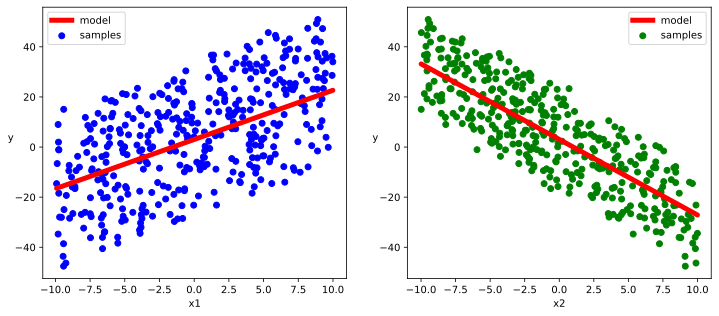

In [16]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

DNN二分类模型

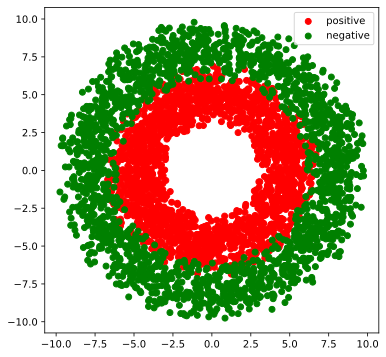

In [17]:
# 准备数据
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000
#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)

#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


In [18]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[-2.9054267   5.295589  ]
 [-4.079486   -3.4765277 ]
 [ 0.2758029  -3.999934  ]
 [ 7.239423    3.6097765 ]
 [ 2.7439067  -1.8938992 ]
 [-0.34975144  6.00277   ]
 [ 4.3822937   1.801024  ]
 [ 5.393372   -4.1571054 ]
 [-5.403918    3.8075457 ]
 [-4.9993267  -4.7038865 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(10, 1), dtype=float32)


In [19]:
# 定义模型

# 此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。
class DNNModel(tf.Module):
  def __init__(self,name = None):
    super(DNNModel, self).__init__(name=name)
    self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
    self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
    self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
    self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
    self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
    self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

  # 正向传播
  @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])
  def __call__(self,x):
    x = tf.nn.relu(x@self.w1 + self.b1)
    x = tf.nn.relu(x@self.w2 + self.b2)
    y = tf.nn.sigmoid(x@self.w3 + self.b3)
    return y

  # 损失函数(二元交叉熵)
  @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
  def loss_func(self,y_true,y_pred): 
    #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
    bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
    return  tf.reduce_mean(bce)

  # 评估指标(准确率)
  @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),tf.TensorSpec(shape = [None,1], dtype = tf.float32)])
  def metric_func(self,y_true,y_pred):
    y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),tf.zeros_like(y_pred,dtype = tf.float32))
    acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
    return acc

    
model = DNNModel()

In [20]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 2.07963419
init metric 0.4


In [21]:
print(len(model.trainable_variables))

6


In [24]:
# 训练模型
@tf.function
def train_step(model, features, labels):
    
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions) 
        
    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    # 计算评估指标
    metric = model.metric_func(labels,predictions)
    
    return loss, metric


def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
        

train_model(model,epochs = 1000)

================================================================================21:57:35
epoch = 100 loss =  0.475892603 accuracy =  0.77
================================================================================21:57:39
epoch = 200 loss =  0.429437906 accuracy =  0.82
================================================================================21:57:43
epoch = 300 loss =  0.434755623 accuracy =  0.84
================================================================================21:57:46
epoch = 400 loss =  0.352861673 accuracy =  0.95
================================================================================21:57:50
epoch = 500 loss =  0.351244956 accuracy =  0.9
================================================================================21:57:54
epoch = 600 loss =  0.382435411 accuracy =  0.87
================================================================================21:57:57
epoch = 700 loss =  0.369424 accuracy =  0.86
======================================

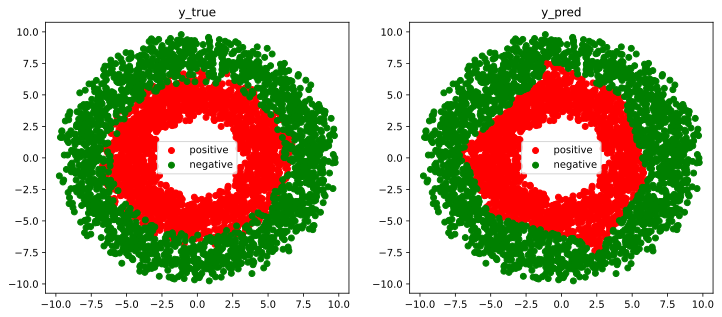

In [25]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");